# Milestone I Natural Language Processing

<h3 style="color:#ffc0cb;font-size:50px;font-family:Georgia;text-align:center;"><strong>Task 1. Text Pre-processing</strong></h3>


Version: 1.0

Environment: Python 3 and Jupyter notebook

Libraries used (please go to `requirements.txt` file for further details)
* sklearn
* collections
* re
* numpy
* nltk
* itertools
* pandas
* os
* pylab
* collections

## Steps
+ 1.1. Examining and loading data

+ 1.2. Basic Text Pre-processing
    * 1.2.1. Extract information from each job advertisement. Perform the following pre-processing steps to the description of each job advertisement;
    * 1.2.2. Tokenize each job advertisement description. The word tokenization must use the following regular expression:
    ```python
    pattern = r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?" 
    ```
    * 1.2.3. All the words must be converted into the lower case;
    * 1.2.4. Remove words with length less than 2.
    * 1.2.5. Remove stopwords using the provided stop words list (i.e, stopwords_en.txt). It is located inside the same downloaded folder.
    * 1.2.6. Remove the word that appears only once in the document collection, based on term frequency.
    * 1.2.7. Remove the top 50 most frequent words based on document frequency.
    * 1.2.8. Save all job advertisement text and information in txt file(s) 
    * 1.2.9. Build a vocabulary of the cleaned job advertisement descriptions, save it in a txt file (please refer to the required output)
    
+ 1.3. Summary
> * Discussion
      
+ 1.4. References


## Introduction

Several websites for finding a job, like au.indeed.com and seek.com.au using keywords, salaries, and job categories, job seekers may search for appropriate positions on any job search website. Previously, the advertiser frequently manually entered an advertised job's type. As a result, the inappropriate employment class did not receive adequate exposure to the appropriate candidate groups.

Automated job classification is now possible because of technological advancements in text pre-processing and analysis, which gives marketers logical options for job categories. This can enhance the user experience of the job-hunting website, decrease human data input errors, and expose more qualified candidates to open positions. We want an automated job advertising categorization system that aids in anticipating the categories of recently entered job adverts to achieve this.

NLP uses a hierarchy to determine which groups of words and sentences belong to each other. The smallest level of text is a token which can be a sentence or an individual word. A group of tokens is called a document, for instance each text file containing job description. A group of documents is called a corpus, in this case the job category folder which containng several job adverisement files inside . Finally, a group of corpus is called a corpora, which can be several job categories we wish to compare and evaluate.

In this **task1** notebook, we are going to explore a job advertisement data set, and focus on pre-processing the description only. In the next task **task2_3**, we will then use the pre-processed text reviews to generate data features and build classification models to predict the job's category.

## Dataset
+ A small collection of job advertisement documents (around 776 jobs) inside the `data` folder.
+ Inside the data folder, there are four different sub-folders: Accounting_Finance, Engineering, Healthcare_Nursing, and Sales, representing a job category.
+ The job advertisement text documents of a particular category are in the corresponding sub-folder.
+ Each job advertisement document is a txt file named `Job_<ID>.txt`. It contains the title, the webindex (some will also have information on the company name, some might not), and the full description of the job advertisement.



## Importing libraries & packages

Install packages to the local environment for the whole project with `pip install -r requirements.txt`

In [118]:
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

from sklearn.datasets import load_files
from nltk import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from nltk import FreqDist
from pylab import *

# import code as a function
from src.utils import *

# import libraries
import numpy as np
import pandas as pd
import re
import os

# ignore warning
import warnings
warnings.filterwarnings('ignore')

# set desired matplotlib gloabal figure size
plt.rcParams["figure.figsize"] = (20,10)

[nltk_data] Downloading package punkt to /Users/tnathu-ai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [119]:
# check the version of the main packages
print("Numpy version: ", np.__version__)
print("Pandas version: ",pd.__version__)
! python --version

Numpy version:  1.23.1
Pandas version:  1.4.3
Python 3.10.4


<h3 style="color:#ffc0cb;font-size:50px;font-family:Georgia;text-align:center;"><strong>1.1 Examining and loading data</strong></h3>


Before doing any pre-processing, we need to load the data into a proper format. 

+ To load the data, we have to explore the data folder. Inside the `data` folder:`Accounting_Finance`, `Engineering`,`Healthcare_Nursing`, and `Sales`, each folder name is a job category.
+ The job advertisement text documents of a particular category are located in the corresponding subfolder as its category.
+ Each job advertisement document is a txt file, named as "Job_<ID>.txt". It contains the title, the webindex,(some will also have information on the company name, some might not), and the full description of the job advertisement. 

In this case, providing that the dataset is given in a very well organised way, we would use a super handy API [`load_files`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_files.html) from `sklearn.datasets`. 
    
**import the function by:**
```python
from sklearn.datasets import load_files  
```

Then directly load the data and labels, for example:
```python
df = load_files(r"data")  
```

The loaded `data` is then a dictionary, with the following attributes:

| **ATTRIBUTES**   | **DESCRIPTION**                                           |
|--------------|---------------------------------------------------------------|
| Webindex     | 8 digit Id of the job advertisement on the website            |
| Title        | Title of the advertised job position                          |
| Company      | Company (test_indexloyer) of the advertised job position      |
| Description  | the description of each job advertisement                     |
| Category     | The category of the advertised job position                   |

In [120]:
# load each folder and file inside the data folder
df = load_files(r"data")

# type of the loaded file
print(f'Data type of the loaded data and labels using sklearn API: {type(df)}')

Data type of the loaded data and labels using sklearn API: <class 'sklearn.utils.Bunch'>


In [121]:
df['target'] # this corresponding to the index value of the 4 categories

array([0, 0, 2, 0, 2, 1, 2, 0, 3, 3, 0, 0, 1, 3, 1, 3, 3, 1, 3, 2, 2, 2,
       3, 3, 0, 2, 2, 2, 0, 2, 3, 1, 2, 0, 1, 3, 3, 1, 1, 0, 2, 2, 2, 2,
       0, 0, 2, 1, 3, 1, 1, 2, 2, 3, 0, 0, 1, 0, 2, 2, 3, 3, 3, 0, 3, 0,
       1, 2, 3, 1, 3, 2, 3, 1, 3, 2, 1, 3, 2, 1, 3, 2, 2, 1, 0, 1, 1, 1,
       3, 0, 3, 1, 3, 2, 2, 0, 2, 3, 2, 1, 0, 1, 1, 2, 0, 3, 0, 1, 3, 2,
       1, 2, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3,
       2, 0, 0, 1, 3, 2, 0, 1, 0, 3, 1, 2, 1, 0, 0, 0, 3, 0, 1, 2, 3, 1,
       1, 1, 2, 1, 0, 1, 0, 1, 0, 1, 1, 2, 0, 2, 2, 0, 2, 3, 2, 2, 0, 2,
       1, 0, 1, 1, 1, 3, 1, 3, 1, 0, 3, 1, 0, 2, 0, 0, 2, 1, 1, 0, 1, 3,
       0, 1, 1, 3, 0, 1, 0, 2, 3, 0, 2, 0, 1, 0, 1, 3, 1, 0, 1, 1, 0, 1,
       0, 1, 2, 1, 3, 1, 2, 3, 1, 1, 2, 0, 0, 1, 2, 0, 3, 2, 3, 2, 2, 3,
       0, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 0, 0, 2, 1, 2, 2, 2, 2, 1, 3, 1,
       2, 1, 2, 3, 2, 3, 0, 1, 3, 0, 2, 1, 0, 2, 1, 2, 0, 2, 1, 1, 1, 2,
       2, 1, 2, 0, 2, 2, 1, 2, 0, 1, 0, 0, 3, 2, 1,

In [122]:
# Name of the categories
df['target_names'] # this corresponding to the name value of the 4 categories

['Accounting_Finance', 'Engineering', 'Healthcare_Nursing', 'Sales']

In [123]:
# loop through the index of the target_names and print the category name
for i in range(len(df['target_names'])):
    print(f'Category at index {i}: {df["target_names"][i]}')

Category at index 0: Accounting_Finance
Category at index 1: Engineering
Category at index 2: Healthcare_Nursing
Category at index 3: Sales


**Create temporary variable and assign a number for testing at that index**

`test_index` is a number to test whether the attribute at that position matches the desired outputs. So we don't need to print to whole lengthly output each test and void memory problems

In [124]:
test_index = 20 # an example to test for the whole task outputs.

df['filenames'][test_index], df['target'][test_index] 

('data/Healthcare_Nursing/Job_00491.txt', 2)

### --------------> OBSERVATION
from the file path and the label we can manually check it's the correct label

In [125]:
# assign variables
full_description, category, directory = df.data, df.target, df.filenames

# the test_index job advertisement description
print(f'Job description: {full_description[test_index]}\n\nCorresponding to the label {category[test_index]} inside the {directory[test_index]} directory')

Job description: b'Title: PERM Unit Mgr RGN Kid minster Flexi ****K due\nWebindex: 71692209\nDescription: Job Title: Unit Manager Reporting to: Registered Manager Job Purpose: To manage in a professional manner the day to day running of the home\xe2\x80\x99s administration, clinical policies and procedures, training and care planning. To implement working practices that monitors the health and welfare of the home\xe2\x80\x99s service users and staff and their respective environments. To promote quality care within a warm friendly ambience. Key Result Areas Managing To work with the Directors to achieve the home\xe2\x80\x99s financial targets. To manage the home in a manner which will not bring the home or service users into disrepute. To maintain confidentiality on all aspects of care and staff management. To ensure all the home\xe2\x80\x99s policies and procedures are implemented and followed by all staff. To inform the Registered Manager immediately if a serious difficulty or event o

### ------> OBSERVATION:

As we can see, the current description is in the **binary** form and read as a byte object (a `b` in front of each description text). Therefore, we need to decode it into the normal string for further pre-processing. This is because the tokenizer cannot apply a string pattern on a bytes-like object. To resolve this, we decode each read `full_description` text using `utf-8` by writing a decode function.

### Decode the description

In [126]:
# function to decode
def decode(l):
    if isinstance(l, list):
        return [decode(x) for x in l]
    else:
        return l.decode('utf-8')

# decode the binary description into utf-8 form and save it to full_description
full_description = decode(full_description)

# print out to test
full_description[test_index]

'Title: PERM Unit Mgr RGN Kid minster Flexi ****K due\nWebindex: 71692209\nDescription: Job Title: Unit Manager Reporting to: Registered Manager Job Purpose: To manage in a professional manner the day to day running of the home’s administration, clinical policies and procedures, training and care planning. To implement working practices that monitors the health and welfare of the home’s service users and staff and their respective environments. To promote quality care within a warm friendly ambience. Key Result Areas Managing To work with the Directors to achieve the home’s financial targets. To manage the home in a manner which will not bring the home or service users into disrepute. To maintain confidentiality on all aspects of care and staff management. To ensure all the home’s policies and procedures are implemented and followed by all staff. To inform the Registered Manager immediately if a serious difficulty or event occurs. Managing Support To delegate responsibility effectively

### ---------------> OBSERVATION:
The current `full_description` contains these attributes:

| **ATTRIBUTES**   | **MEANING**                                        |
|--------------|----------------------------------------------------|
| Webindex     | 8 digit Id of the job advertisement on the website |
| Title        | Title of the advertised job position               |
| Company      | Company (test_indexloyer) of the advertised job position  |
| Description  | the description of each job advertisement          |

I only want the description to perform text-preprocessing in task 1 and other attributes for further exploring different features of a job advertisement, e.g., the title in task 3, to test the accuracy. Therefore, I will extract each above attribute inside the `full_description`

<h3 style="color:#ffc0cb;font-size:50px;font-family:Georgia;text-align:center;"><strong>1.2 Pre-processing</strong></h3>

* 1.2.1. Extract information from each job advertisement. Perform the following pre-processing steps to the description of each job advertisement;
* 1.2.2. Tokenize each job advertisement description. The word tokenization must use the following regular expression, r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?";
* 1.2.3. All the words must be converted into the lower case;
* 1.2.4. Remove words with length less than 2.
* 1.2.5. Remove stopwords using the provided stop words list (i.e, stopwords_en.txt). It is located inside the same downloaded folder.
* 1.2.6. Remove the word that appears only once in the document collection, based on term frequency.
* 1.2.7. Remove the top 50 most frequent words based on document frequency.
* 1.2.8. Save all job advertisement text and information in txt file(s) 
* 1.2.9. Build a vocabulary of the cleaned job advertisement descriptions, save it in a txt file

## 1.2.1 Extract information from each job advertisement

We use regular expression to extract different parts of description and use list comprehension to return the desire output across all document

In [127]:
# Extract description, title, webindex,  from each job advertisement and test using test_index

# Extract description
def extract_description(full_description):
    description = [re.search(r'\nDescription: (.*)', str(i)).group(1) for i in full_description]
    return description
description = extract_description(full_description)
print(f'Job description at index {test_index}:\n{description[test_index]}\n\n')

# Extract title
def extract_title(full_description):
    title = [re.search(r'Title: (.*)', str(i)).group(1) for i in full_description]
    return title
title = extract_title(full_description)
print(f'Job title at index {test_index}:\n{title[test_index]}\n\n')

# Extract webindex
def extract_webindex(full_description):
    webindex = [re.search(r'Webindex: (.*)', str(i)).group(1) for i in full_description]
    return webindex
webindex = extract_webindex(full_description)
print(f'Job webindex at index {test_index}:\n{webindex[test_index]}\n\n')

# Extract company
def extract_company(company):
    company = [re.search(r'Company: (.*)', str(i)).group(1) if re.search(r'Company: (.*)', str(i)) else "NA" for i in company]
    return company
company = extract_company(full_description)
print(f'Job company at index {test_index}:\n{company[test_index]}\n')

Job description at index 20:
Job Title: Unit Manager Reporting to: Registered Manager Job Purpose: To manage in a professional manner the day to day running of the home’s administration, clinical policies and procedures, training and care planning. To implement working practices that monitors the health and welfare of the home’s service users and staff and their respective environments. To promote quality care within a warm friendly ambience. Key Result Areas Managing To work with the Directors to achieve the home’s financial targets. To manage the home in a manner which will not bring the home or service users into disrepute. To maintain confidentiality on all aspects of care and staff management. To ensure all the home’s policies and procedures are implemented and followed by all staff. To inform the Registered Manager immediately if a serious difficulty or event occurs. Managing Support To delegate responsibility effectively and within legal boundaries. To ensure through clinical st

## 1.2.2 + 1.2.3 
## Tokenize description using regular expression & lowercase all words

+ Case normalization is easy to perform, but it is a highly powerful technique. It will greatly decrease the vocabulary size for a big corpus, allowing the analysis algorithms to concentrate on the diverse meanings of tokens rather than their situations.

+ The same case with using regex only to extract the desired pattern that we only want meaningful words not slash, comma, etc. do not carry any meaning themself

In [128]:
def tokenizeDescription(raw_description):
    """
        This function first convert all words to lowercases,
        it then segment the raw description into sentences 
        and tokenize each sentences base on the regex pattern
        and convert the description to a list of tokens.
    """
    description = raw_description.lower() # convert all words to lowercase

    # segment into sentences
    sentences = sent_tokenize(description)

    # tokenize each sentence
    pattern = r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?"
    tokenizer = RegexpTokenizer(pattern)
    token_lists = [tokenizer.tokenize(sen) for sen in sentences]

    # merge them into a list of tokens
    tokenised_description = list(chain.from_iterable(token_lists))
    return tokenised_description

# list comprehension, generate a list of tokenized description
tk_description = [tokenizeDescription(r) for r in description] 

# I also want a list of tokenized title for task 3
tk_title = [tokenizeDescription(r) for r in title] 

# I also want a list of tokenized company for task 3
tk_company = [tokenizeDescription(r) for r in company] 

# print out to test
print("Raw description:\n",description[test_index],'\n')
print("Tokenized description:\n",tk_description[test_index],'\n\n')
print("The original number of Tokenized description tokens: ",len(tk_description))

Raw description:
 Job Title: Unit Manager Reporting to: Registered Manager Job Purpose: To manage in a professional manner the day to day running of the home’s administration, clinical policies and procedures, training and care planning. To implement working practices that monitors the health and welfare of the home’s service users and staff and their respective environments. To promote quality care within a warm friendly ambience. Key Result Areas Managing To work with the Directors to achieve the home’s financial targets. To manage the home in a manner which will not bring the home or service users into disrepute. To maintain confidentiality on all aspects of care and staff management. To ensure all the home’s policies and procedures are implemented and followed by all staff. To inform the Registered Manager immediately if a serious difficulty or event occurs. Managing Support To delegate responsibility effectively and within legal boundaries. To ensure through clinical standards and

#### Text Descriptive Statistic

We are interested to know a few statistics at this very beginning stage, including:
* The total number of tokens across the corpus
* The total number of types across the corpus, i.e., the size of vocabulary 
* The so-called [lexical diversity](https://en.wikipedia.org/wiki/Lexical_diversity) refers to the ratio of different unique word stems (types) to the total number of words (tokens).  
* The average, minimum, and the maximum number of the token (i.e., document length) in the dataset.

In the following, we wrap all these up as a function, `stats_print`. Since we will reuse this function several times, we put it into the python module inside the folder `src/utils.py` to make it easier to recall later to compare these statistic values before and after pre-processing.

In [129]:
print("Intial text statistic:\n")
stats_print(tk_description)

Intial text statistic:

Vocabulary size:  9834
Total number of tokens:  186952
Lexical diversity:  0.052601737344345076
Total number of description: 776
Average description length: 240.91752577319588
Maximum description length: 815
Minimum description length: 13
Standard deviation of description length: 124.97750685071483


## Task 1.2.4 Remove words with length less than 2.
remove any token that only contains a single character (a token that of length less than 2).

In [130]:
# assign variable to see tokenized description has the length less than 2
tk_description_less_length_2 = [[w for w in description if len(w) < 2] for description in tk_description]

# test
print(f'Before removing, the words that appear with length less than 2 at index {test_index}:{tk_description_less_length_2[test_index]}')

# filter out single character tokens
tk_description = [[w for w in description if len(w) >=2] for description in tk_description]

# assign variable to see tokenized description has the length less than 2
tk_description_less_length_2 = [[w for w in description if len(w) < 2] for description in tk_description]

# test
print(f'Before removing, the words that appear with length less than 2 at index {test_index}:{tk_description_less_length_2[test_index]}')

Before removing, the words that appear with length less than 2 at index 20:['a', 's', 's', 'a', 's', 'a', 's', 'a', 's', 'a', 's', 'a', 'a', 'a', 's', 's', 's', 'a', 'a', 's']
Before removing, the words that appear with length less than 2 at index 20:[]


In [131]:
# few statistic
stats_print(tk_description)

Vocabulary size:  9808
Total number of tokens:  180913
Lexical diversity:  0.05421390392066905
Total number of description: 776
Average description length: 233.13530927835052
Maximum description length: 795
Minimum description length: 13
Standard deviation of description length: 121.6048654015839


## Task 1.2.5 Remove stopwords using the provided stop words list
> **NOTE**: The purpose of this task is to pre-process the text reviews, and later on, we will use the pre-process text to build a sentiment analysis model. The stop word removal process requires careful consideration in this type of task.

Remove the stop words from the tokenized text inside `stopwords_en.txt` file

In [132]:
# remove the stop words inside `stopwords_en.txt` from the tokenized text
stopwords_file = 'stopwords_en.txt'

# read the stop words into a list
with open(stopwords_file, 'r') as f:
    stop_words = f.read().splitlines() 
print(f'The number of stop words inside {stopwords_file} is {len(stop_words)} including:\n\n{stop_words}')

The number of stop words inside stopwords_en.txt is 571 including:

['a', "a's", 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after', 'afterwards', 'again', 'against', "ain't", 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', "aren't", 'around', 'as', 'aside', 'ask', 'asking', 'associated', 'at', 'available', 'away', 'awfully', 'b', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'both', 'brief', 'but', 'by', 'c', "c'mon", "c's", 'came', 'can', "can't", 'cannot', 'cant', 'cause', 'causes', 'certain', 'certainly', 'changes', 'clearly', 'co', 'com', 'come', 'comes', 'concerning', 'conse

### -----------> OBSERVATION:
+ There 571 stopwords in total, which are often function words in English, like description (e.g. "the", and "an"), pronouns (e.g. "he", "him", and "they"), pdescription (e.g., "well", "however" and "thus"), etc, and universal words in all job advertisement (e.g.'ask', 'asking', 'used', and 'useful')

+ There is no universal list of stop words. This is just follow the requirement description

In [133]:
# print the test_index index description length before removing stop words
print("The number of tokens in the test_index index description BEFORE removing stop words:",len(tk_description[test_index]))

# convert stop words list into a set to speed up the process to checking
stopwordSet = set(stop_words)

# filter stop words in each document for the whole tokenized description
tk_description = [[token for token in description if token not in stopwordSet] for description in tk_description]

# print the test_index index description length after removing stop words
print("The number of tokens in the test_index index description AFTER removing stop words:",len(tk_description[test_index]))

# few statistic
stats_print(tk_description)

The number of tokens in the test_index index description BEFORE removing stop words: 795
The number of tokens in the test_index index description AFTER removing stop words: 440
Vocabulary size:  9404
Total number of tokens:  107161
Lexical diversity:  0.0877558066834016
Total number of description: 776
Average description length: 138.09407216494844
Maximum description length: 487
Minimum description length: 12
Standard deviation of description length: 73.07847897002313


### ---------> OBSERVATION:

The list comprehension 
```python
    [token for token in description if token not in stop_words]
```
For each word in each Job Advertisement description, keep the word if the word is **NOT** in the stopword list. Checking for membership of a value in a list takes time proportional to the list's length in the average and worst cases. 
=> It causes the above code to run quite slow as we need to do the check for every word in each description
and both the total number of tokens and the size of stopword list are large.

However, if we have hashable items, which means both the item order and duplicates are disregarded, Python `set` is a better choice than `list`. The former runs much faster than the latter in terms of searching
a large number of hashable items. Indeed, `set` takes constant time to check the membership.
Let's try converting the stopword list into a stopword set, then search to remove all the stopwords.
we can construct a `stopwordSet` from the stopword list and change the  `stop_words` (a list) to `stopwordSet`,

# Removing the Most and Less Frequent Words

The frequency distribution can tell us how frequent a word is in a given corpus in terms of either **term frequency** or **document frequency**:
* **Term frequency** the total number of word tokens are distributed across the whole corpus regardless which document it is in.
* **Document frequency** counts the number of documents a word occurs. 

For instance, if a word appear 3 times in a document, when we count the term frequency, this will be added 3 into the total number of occurrence; however, for document frequency, this will still be counted as 1 only. 

The words that only appear once or twice if the most prevalent terms don't help the subsequent text analysis tasks other than contributing noises? The frequency of word kinds in a particular corpus is another intriguing statistic in this case. Here, we will utilize document frequency as an illustration:

The actual y values: [4643, 1215, 654, 409, 305, 227, 167, 163, 117, 111, 1072, 194, 90, 37]


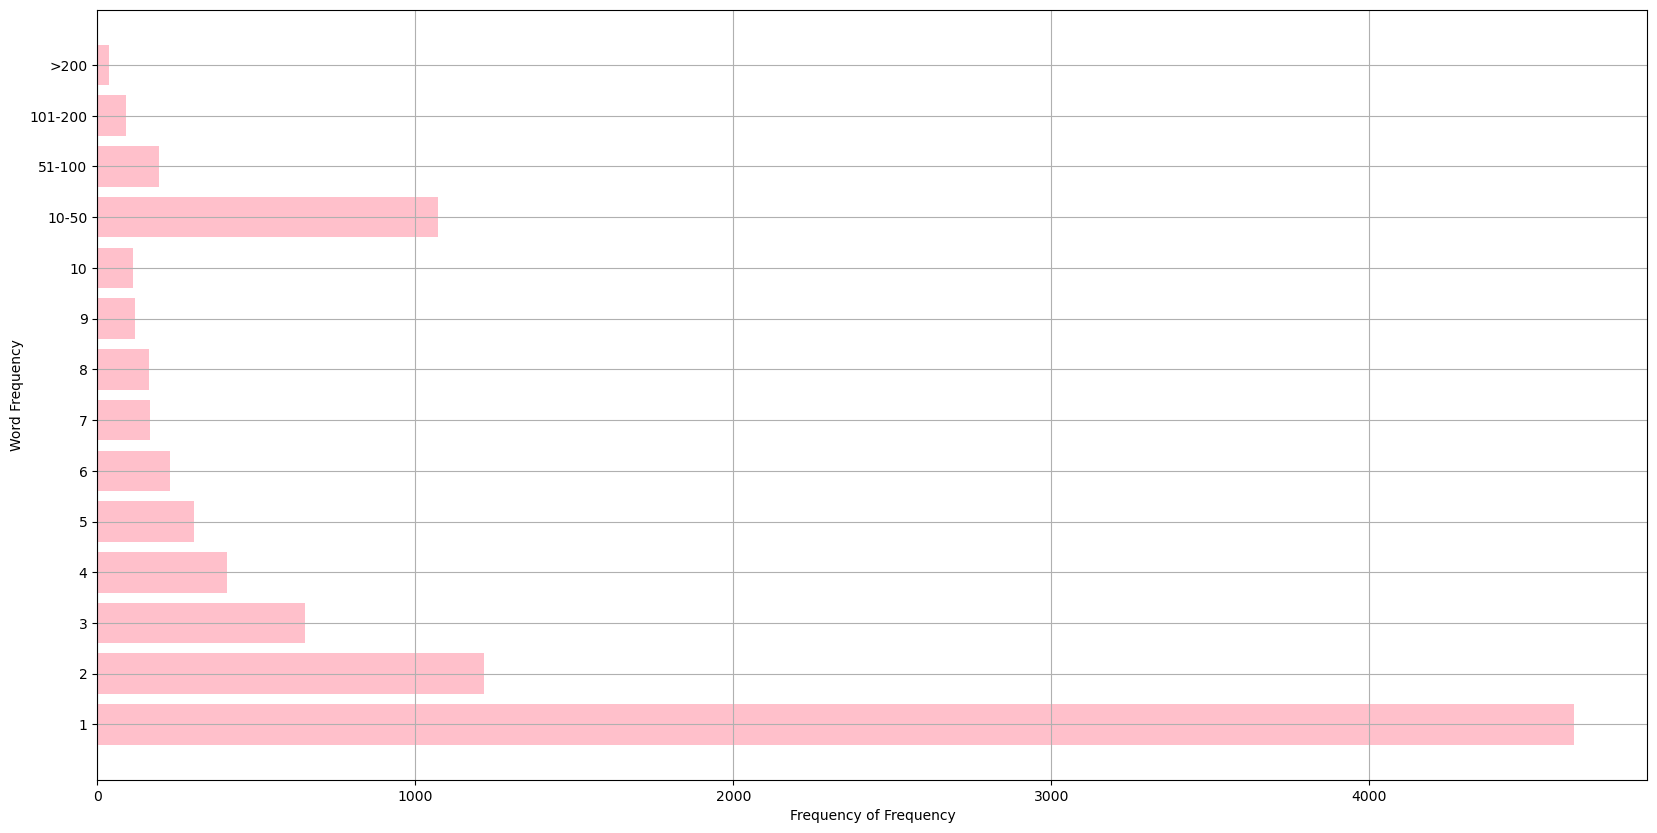

In [134]:
words = list(chain.from_iterable([set(description) for description in tk_description]))
doc_fd = FreqDist(words)
ffd = FreqDist(doc_fd.values()) # ffd frequency of frequencies values

y = [0]*14 # number of the y axis category we want to show

for k, v in ffd.items(): # iterate the dictionary items of ffd
    if k <= 10: # show the frequency value for each frequency of frequency equal to or lower than 10
        y[k-1] = v
    elif 10 < k <= 50: # aggregate the frequency of frequency values larger than 10 but smaller than or equal to 20
        y[10] =  y[10] + v
    elif 50 < k <= 100: # aggregate the frequency of frequency values larger than 50 but smaller than or equal to 100
        y[11] =  y[11] + v
    elif 100 < k <= 200: # aggregate the frequency of frequency values larger than 100 but smaller than or equal to 200
        y[12] =  y[12] + v
    else:
        y[13] =  y[13] + v # aggregate the frequency of frequency values larger than 200
x = range(1, 15) # generate integer from 1 to 14

ytks = list(map(str, range(1, 11))) # covert a integer list to a string list, we will get ['0','1',...,'10']
# appending other categories,  '10-50', '51-100', '101-200', '>200'
# will use ytks as the values on the y-axis
ytks.append('10-50') 
ytks.append('51-100')
ytks.append('101-200')
ytks.append('>200')
print(f'The actual y values: {y}')
barh(x,y, align='center', color='pink') # plot the bar chart
yticks(x, ytks) # annotate x and y axies
xlabel('Frequency of Frequency') # set x-axis caption
ylabel('Word Frequency') # set y-axis caption
grid(True) # make the bar chart grided, easier to view and compare
# save the figure inside the folder `media/figure`
plt.savefig('media/figure/word_frequency.png', dpi=300, bbox_inches='tight')
show()

### ------------> OBSERVATION:

The horizontal bar chart generated above shows how many word types occur with a certain frequency.

There are very small number (37) of types occurring over 200 times and therefore individually accounting for less than 1% (37/9404) of the vocabulary. 

However, on the other extreme, about 50% (4643/9404) of the word types occur only once in the corpus.

## Task 1.2.6 Remove the word that appears only once in the document collection, based on term frequency

What are the most frequent words in terms of document frequency?
Here we are going to count how many documents a word appears in.
Instead of writing nested FOR loops to count the document frequency for each word,
we can use  `FreqDist()` jointly with  `set()` as follows:
1. Apply  `set()` to each Job Advertisement description to generate a set of unique words in the description and save all sets in a list.
```python
    [set(description) for description in tokenised_description]
```
2. Similar to what we have done before, we then put all the words in a list using  `chain.from_iterable` and pass it to `FreqDist`.

The first step makes sure that each word in an description appears only once, thus the total number of 
times a word appears in all the sets is equal to the number of documents containing that word.

* find out the list of words that appear only once in the **entire corpus**
* remove these less frequent words from each tokenized description text

We first need to find out the set of less frequent words by using the `hapaxes` function applied on the **term frequency** dictionary. 

Let's further remove those words that occur only once. 
To get those words, we can write the code like
```python
    lessFreqWords = set([k for k, v in doc_fd.items() if v < 2])
```
or choose to use `hapaxes()` function, which return a list of all tokens that occur once (hapax legomena).

In [135]:
from nltk.probability import *
from itertools import chain

words = list(chain.from_iterable(tk_description)) # we put all the tokens in the corpus in a single list
term_fd = FreqDist(words) # compute term frequency for each unique word/type

# Using hapaxes() to see less frequent words in term frequency
lessFreqWords = set(term_fd.hapaxes())
print(f'The number of words that appear only once in the entire corpus is: {len(lessFreqWords)}\n')

# test
lessFreqWords

The number of words that appear only once in the entire corpus is: 4186



{'valueadd',
 "manager's",
 'coleraine',
 'kegworth',
 'mrk',
 'medically',
 'selfmotived',
 'cascaded',
 'lgapiuenpcvwow',
 'needham',
 'quoted',
 'registerednursermnnbarchesterhealthcare',
 'conveyers',
 'koonerpertemps',
 'operability',
 'commencement',
 'environmentto',
 'prescriptions',
 'realtime',
 'bodmin',
 'requisite',
 'exmouth',
 'amending',
 'announce',
 'football',
 'accurancy',
 'psychometric',
 'tenanted',
 'mackenzieedenscott',
 'careersflamehealth',
 'mccall',
 'mansion',
 'projectmanager',
 'cannulate',
 'shaving',
 'ryanh',
 'attachment',
 'joannaaesco',
 'stations',
 'scratch',
 'nice',
 'passes',
 'rated',
 'whiteshall',
 'dewrance',
 'conformance',
 'reef',
 'gartnavel',
 'removal',
 'portugal',
 'riskandcompliancemanagercardpaymentswatford',
 'pipefitting',
 'redirects',
 'comint',
 'outturn',
 'yourprimary',
 'conforms',
 'gave',
 'utilization',
 'omb',
 'timehours',
 'constructors',
 'frome',
 'graduatesalesexecutiveconstructionproductssurrey',
 'serviceuser',

### -------> OBSERVATION:

Most of the words do not carry any meaning which indicates maybe typos inside the description we might fix it or in this case I would eliminate it

In [136]:
def removeLessFreqWords(description):
    return [w for w in description if w not in lessFreqWords]

tk_description = [removeLessFreqWords(description) for description in tk_description]

# view the updated statistic
stats_print(tk_description)

Vocabulary size:  5218
Total number of tokens:  102975
Lexical diversity:  0.05067249332362224
Total number of description: 776
Average description length: 132.69974226804123
Maximum description length: 471
Minimum description length: 12
Standard deviation of description length: 70.3782402519735


## Task 1.2.7 Remove the top 50 most frequent words based on document frequency.

In [137]:
words = list(chain.from_iterable([set(description) for description in tk_description]))
doc_fd = FreqDist(words)  # compute document frequency for each unique word/type
top50MostFreqWords = doc_fd.most_common(50)
top50MostFreqWords

[('experience', 586),
 ('role', 499),
 ('work', 453),
 ('team', 431),
 ('working', 407),
 ('skills', 366),
 ('client', 358),
 ('job', 348),
 ('company', 343),
 ('business', 342),
 ('uk', 316),
 ('excellent', 309),
 ('management', 301),
 ('based', 287),
 ('apply', 286),
 ('opportunity', 280),
 ('salary', 270),
 ('required', 269),
 ('successful', 267),
 ('support', 261),
 ('join', 252),
 ('candidate', 248),
 ('service', 242),
 ('knowledge', 241),
 ('development', 235),
 ('leading', 234),
 ('high', 224),
 ('cv', 223),
 ('manager', 220),
 ('www', 220),
 ('training', 214),
 ('sales', 211),
 ('strong', 211),
 ('including', 209),
 ('provide', 209),
 ('services', 208),
 ('ability', 201),
 ('contact', 200),
 ('position', 199),
 ('recruitment', 196),
 ('full', 194),
 ('benefits', 193),
 ('posted', 192),
 ('jobseeking', 191),
 ('originally', 191),
 ('clients', 187),
 ('include', 187),
 ('good', 187),
 ('essential', 186),
 ('information', 184)]

### --------> OBSERVATION:

Each unique token is a key, and the value is its corresponding frequency. The list above contains the 50 most frequent words. We can see that it is mostly dominated by the stop words of the English language, which occurs in most job descriptions making it cliché, which tells us nothing about the meaning of the text.

#### Cumulative Frequency Plot
We use [matplotlib.lines.Line2D](https://matplotlib.org/stable/api/_as_gen/matplotlib.lines.Line2D.html)
to generate a cumulative frequency plot for proportion of the text <font color="pink"><b>fd.plot(50, cumulative=True)</b></font>. These 50 words account for about 13% (i.e., 13000/102975, where 102975 is the total number of tokens) of the entire Job Ad corpus.

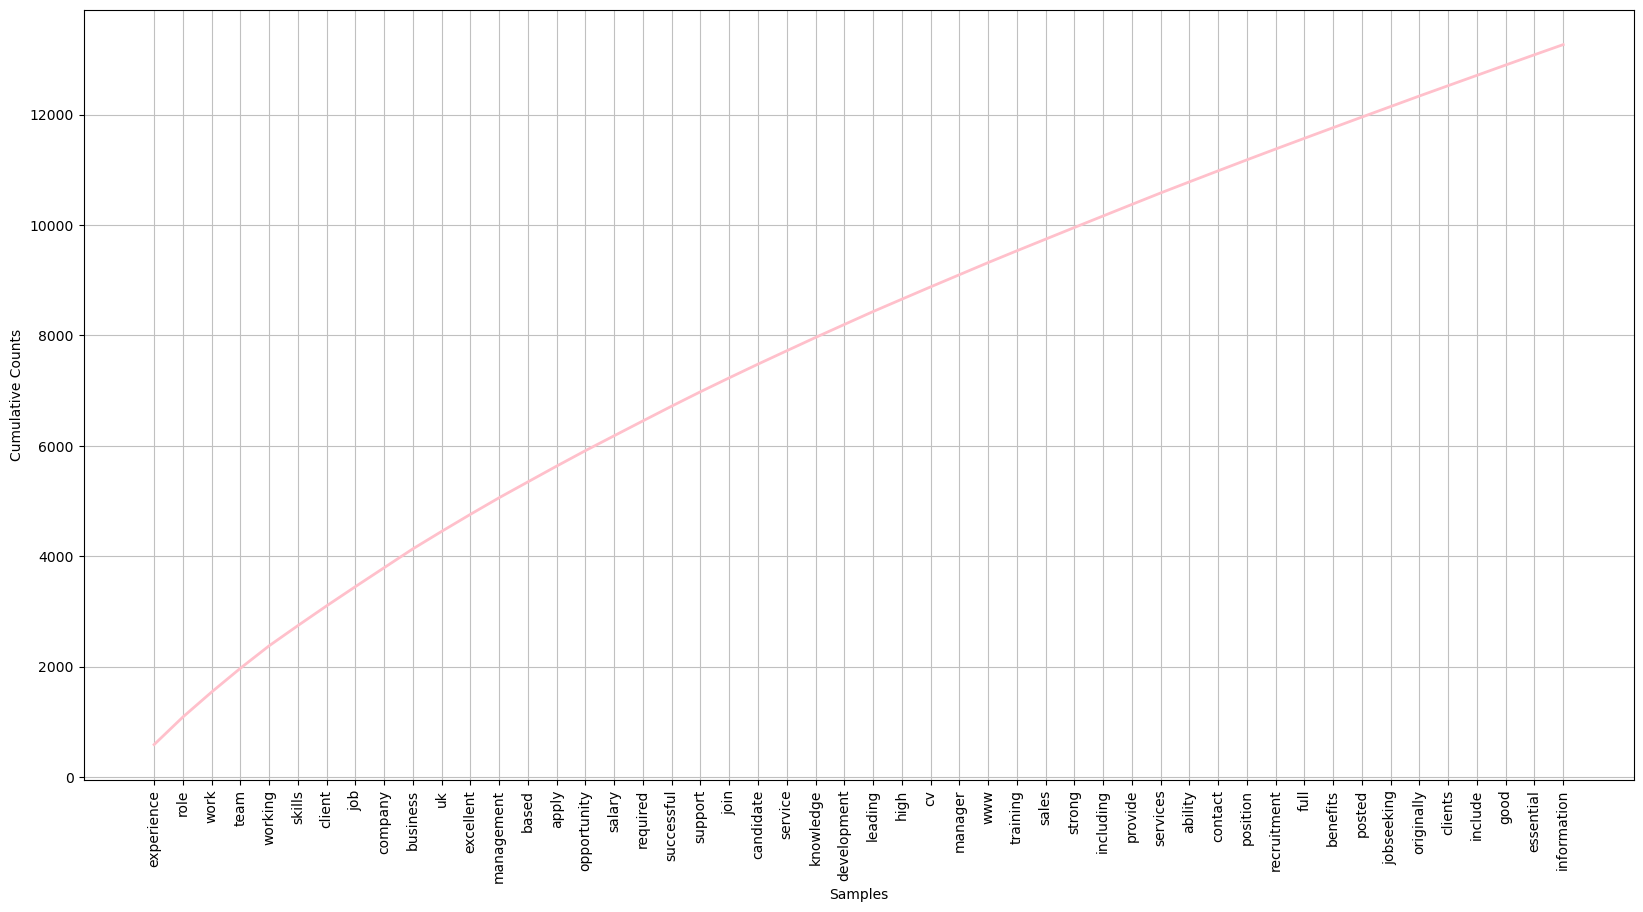

In [138]:
# cumulative frequency plot for most common 50 words
plt = doc_fd.plot(50, cumulative=True, color='pink')
# # save the figure inside the folder `media/figure`
plt.figure.savefig('media/figure/cumulative_frequency.png', dpi=300, bbox_inches='tight')
show()

### -----------> OBSERVATION:

From the previous printout of the most frequent words, we can see there might be some quite useful words. Before we decide to remove those words from our vocabulary, it might be worth checking what those words mean and the context of those words. 

Fortunately, NLTK provides a concordance function in the `nltk.text` module. A **concordance** view shows us every occurrence of a given the word, together with the corresponding context. For example:

In [139]:
textList = nltk.Text(words) # Create the text of tokens
textList.concordance('training') # shows the concordance view of the token 'said'

Displaying 25 of 214 matches:
nt cv users hospital care uptodate training conditions dedication dependent da
husiastic planned hospital care uk training hpc echadwickeclypserecruitment wh
ring maintain possibility positive training counties drive extremely face pass
 financial workshop areas maintain training extremely assessment days resource
es financial talented presentation training path face resources phone horsham 
ay order ensuring driven easily uk training buying build drive whilst weekdays
territory periods chain specialist training head uk resource erp problem enabl
pancy maintain audits care promote training reviews staff total daily director
 areas managerial maintain care uk training staff resource effect conditions c
es senior ideal users crawley care training staff advantageous sussex forward 
ls cv huddersfield specialist care training uk subject street nursing covering
es financial interest enthusiastic training professionals drive build extremel
r development ph worki

In [140]:
def removeMostFreqWords(description):
    return [w for w in description if w not in top50MostFreqWords]

tk_description = [removeMostFreqWords(description) for description in tk_description]

stats_print(tk_description)

Vocabulary size:  5218
Total number of tokens:  102975
Lexical diversity:  0.05067249332362224
Total number of description: 776
Average description length: 132.69974226804123
Maximum description length: 471
Minimum description length: 12
Standard deviation of description length: 70.3782402519735


### The Updated Statistics
In the above, we have done all required pre-processed steps, now let's have a look at the statistics again:

In [141]:
print(f'The final statistic description after pre-processing:\n')
stats_print(tk_description)

The final statistic description after pre-processing:

Vocabulary size:  5218
Total number of tokens:  102975
Lexical diversity:  0.05067249332362224
Total number of description: 776
Average description length: 132.69974226804123
Maximum description length: 471
Minimum description length: 12
Standard deviation of description length: 70.3782402519735


**Recall, from the beginning, we have the following:**  
_____________________________________________

+ Vocabulary size:  9834
+ Total number of tokens:  186952
+ Lexical diversity:  0.052601737344345076
+ Total number of description: 776
+ Average description length: 240.91752577319588
+ Maximum description length: 815
+ Minimum description length: 13
+ Standard deviation of description length: 124.97750685071483
_____________________________________________


### ------------> OBSERVATION:

**We've shrunk more than 53% of vocabulary size (number of types across the corpus).**

* The total number of tokens across the corpus shrunk by more than 55%
* The ratio of different unique words stems from a significantly reduced total number of tokens.  
* The average number of the token (i.e., document length) in the dataset shrunk by more than 55%
* The maximum Maximum description length decreases by about 58%
* The minimum description length increases by 7.7%
* The Standard deviation of description length shrunk by about 56%

## Task 1.2.8 Save all job advertisement text and information 
+ Save the vocabulary, bigrams, and job advertisement txt format.
+ We are going to store all the preprocessed description texts and their corresponding labels into files for task 2.

#### `.txt` files
* `description.txt`: all the tokenized descriptions are stored in a .txt file
    * each line is a description text, which contains all the tokens of the description text, separated by a space ' '
* `category.txt`: All the corresponding labels are stored in a .txt file
    * each line is a label (one of these 4 values: 0,1,2,3)
* `title.txt`: All the corresponding titles are stored in a .txt file
    * each line is a title

In [142]:
# save description text
def save_description(descriptionFilename,tk_description):
    out_file = open(descriptionFilename, 'w') # creates a txt file and open to save the descriptions
    # join the tokens in an description with space, and write the obtained string to the txt document
    string = "\n".join([" ".join(description) for description in tk_description]) 
    out_file.write(string)
    out_file.close() # close the file

# save the category corresponding with the description text
def save_category(categoryFilename,category):
    out_file = open(categoryFilename, 'w') # creates a txt file and open to save category
    string = "\n".join([str(s) for s in category])
    out_file.write(string)
    out_file.close() # close the file

# save the title corresponding with the description text
def save_title(titleFilename,title):
    out_file = open(titleFilename, 'w') # creates a txt file and open to save title
    string = "\n".join([str(s) for s in title])
    out_file.write(string)
    out_file.close() # close the file

# create a directory to save the data
if not os.path.exists('saved_txt_files/data/'):
    os.makedirs('saved_txt_files/data/')

# save description into txt file
descriptionFilename = "saved_txt_files/data/description.txt"
save_description(descriptionFilename,tk_description)
print(f'Successfully saved description into {descriptionFilename}')

# save category into txt file
categoryFilename = "saved_txt_files/data/category.txt"
save_category(categoryFilename,category)
print(f'Successfully saved category into {categoryFilename}')

# save title into txt file
titleFilename = "saved_txt_files/data/title.txt"
save_title(titleFilename,title)
print(f'Successfully saved title into {titleFilename}')

Successfully saved description into saved_txt_files/data/description.txt
Successfully saved category into saved_txt_files/data/category.txt
Successfully saved title into saved_txt_files/data/title.txt


#### `.csv` file
* `job_ad.csv`: store information into a Dataframe and save into a CSV file
    * the dataframe contains 776 observations and 6 attributes including `Title`, `Webindex`, `Company`, `Description`, `Tokenized Description`,`Category`

In [143]:
# loop through the index of the target_names and print the category name
for i in range(len(df['target_names'])):
    print(f'Category at index {i}: {df["target_names"][i]}')

Category at index 0: Accounting_Finance
Category at index 1: Engineering
Category at index 2: Healthcare_Nursing
Category at index 3: Sales


In [144]:
# convert job ad to a dataframe
job_ad = pd.DataFrame({'Webindex': webindex, 'Title': title, 'Tokenized Title': tk_title, 'Company': company, 'Tokenized Company': tk_company, 'Description': description,'Tokenized Description': tk_description, 'Category': category})

# updated column Tokenized Description
job_ad['Tokenized Description'] = job_ad['Tokenized Description']

# updated column & replace the value in Category 
job_ad['Category'] = job_ad['Category'].replace([0,1,2,3],['Accounting_Finance','Engineering','Healthcare_Nursing','Sales'])

# updated column & cast Webindex to int
job_ad['Webindex'] = job_ad['Webindex'].astype(int)

# save job ad to csv file
job_ad.to_csv('job_ad.csv', index=False)

# print basic info about the job_ad data frame
print(job_ad.info())

# print first 3 rows
job_ad.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Webindex               776 non-null    int64 
 1   Title                  776 non-null    object
 2   Tokenized Title        776 non-null    object
 3   Company                776 non-null    object
 4   Tokenized Company      776 non-null    object
 5   Description            776 non-null    object
 6   Tokenized Description  776 non-null    object
 7   Category               776 non-null    object
dtypes: int64(1), object(7)
memory usage: 48.6+ KB
None


,Webindex,Title,Tokenized Title,Company,Tokenized Company,Description,Tokenized Description,Category
0,68997528,Finance / Accounts Asst Bromley to ****k,"[finance, accounts, asst, bromley, to, k]",First Recruitment Services,"[first, recruitment, services]",Accountant (partqualified) to **** p.a. South ...,"[accountant, partqualified, south, east, londo...",Accounting_Finance
1,68063513,Fund Accountant Hedge Fund,"[fund, accountant, hedge, fund]",Austin Andrew Ltd,"[austin, andrew, ltd]",One of the leading Hedge Funds in London is cu...,"[leading, hedge, funds, london, recruiting, fu...",Accounting_Finance
2,68700336,Deputy Home Manager,"[deputy, home, manager]",Caritas,[caritas],An exciting opportunity has arisen to join an ...,"[exciting, opportunity, arisen, join, establis...",Healthcare_Nursing


## Task 1.2.9 Build a vocabulary of the cleaned job advertisement descriptions

`vocab.txt`

This file contains the unigram vocabulary, one each line, in the following format: `word_string:word_integer_index` sorted in **alphabetical order**, and the **index value starts from 0**. This file is the key to interpreting sparse encoding. For instance, in the following example, the word `benefit` is the word_string word (the corresponding integer_index as 4) in the vocabulary. 

In [145]:
def write_vocab(vocab, filename):
    with open(filename, 'w') as f:  # creates a txt file open in write mode
        for i, word in enumerate(vocab):
            # write each index and vocabulary word, note that index start from 0
            f.write(word + ':' + str(i) + '\n')
            
# convert tokenized description into a alphabetically sorted list
vocab = sorted(list(set(chain.from_iterable(tk_description))))

# save the sorted vocabulary list into a file according to the required format
write_vocab(vocab, 'saved_txt_files/vocab.txt')


# print out the first 10 words in the vocabulary to test
print(vocab[:10])

['aap', 'aaron', 'aat', 'abb', 'abenefit', 'aberdeen', 'abi', 'abilities', 'ability', 'abreast']


### [Convert all `.ipynb` notebooks in the same directory into `.py` files](https://nbconvert.readthedocs.io/en/latest/usage.html#reveal-js-html-slideshow)

In [146]:
# # The .py format of the jupyter notebook
# for fname in os.listdir():
#     if fname.endswith('.ipynb'):
#         os.system(f'jupyter nbconvert {fname} --to script')

<h3 style="color:#ffc0cb;font-size:50px;font-family:Georgia;text-align:center;"><strong>1.3 Summary</strong></h3>

We have demonstrated the basic text pre-processing steps of sentence segmentation and tokenization. We have covered the fundamentals of text pre-processing steps: 
> + Case Normalization, 
> + Stop Word Removing, 
> + Words base on term frequency and document frequency Removing, 
> + Regex Tokenization

We also performed basic text pre-processing for title and company for task 3

There is no one ideal approach to text pre-processing. It all relies on the corpus and the type of text analysis we're going to do. What qualifies as a token is the main concern of the tokenization process—some text analysis tasks. As previously noted, even if these actions have varied effects on the text, they all have one thing in common: they all result in smaller vocabulary sizes.

> # Discussion

>> * The stopword removal technique requires extra consideration of **negative sentences**. In some cases, removing stop words from a phrase might eliminate important details and change the statement's context. For instance, while conducting a sentiment analysis, the term "not," despite being a stop word, contains crucial information because "do" and "not do" clearly have radically different meanings. Failure to eliminate the stop word might ruin the purpose of the whole context and confuse the algorithm. We must constantly carefully analyze these circumstances and build our list of "stop phrases" to be eliminated to fit our goals.

>> * For larger data sizes, it is highly recommended to reduce the vocabulary size further to either **Stemming or Lemmatization** of the words to their roots.

>> * The downstream analysis will determine how we should treat the text. Should we pre-process the `title` information if we put it into the classification model? Or ought we only concentrate on the `description` itself? Based on the analytical work's objectives, we can choose the appropriate downstream analysis task. For instance, we may use the whole document when doing tasks like document classification and clustering. In contrast, performing functions like document summary and information retrieval, a smaller unit, such as a paragraph or phrase, may be used.

<h3 style="color:#ffc0cb;font-size:50px;font-family:Georgia;text-align:center;"><strong>1.4 References</strong></h3>


+ [1] Sentence boundary disambiguation. https://en.wikipedia.org/wiki/Sentence_boundary_disambiguation
+ [2] Tokenization. https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html  
+ [3] wer Guide to Natural Language Processing (NLP). https://towardsdatascience.com/wer-guide-to-natural-language-processing-nlp-48ea2511f6e1  
+ [4] Introduction to Natural Language Processing for Text. https://towardsdatascience.com/introduction-to-natural-language-processing-for-text-df845750fb63  
+ [5] [Accessing Text Corpora and Lexical Resources](http://www.nltk.org/book/ch02.html): Chapter 2 of "Natural Language Processing with Python" By Steven Bird, Ewan Kelin & Edward Loper.  
+ [6]. [Corpus Readers](http://www.nltk.org/howto/corpus.html#tagged-corpora): An NLTK tutorial on accessing the contents of a diverse set of corpora.
+ [7] Stop words. https://en.wikipedia.org/wiki/Stop_word  
+ [8] Bird, Steven, Edward Loper and Ewan Klein (2009), [Natural Language Processing with Python](http://www.nltk.org/book/). O’Reilly Media Inc.  
+ [9] Convert script to Python file. https://nbconvert.readthedocs.io/en/latest/usage.html#reveal-js-html-slideshow
+ [10] matplotlib.lines.Line2D. https://matplotlib.org/stable/api/_as_gen/matplotlib.lines.Line2D.html
+ [11] lexical diversity. https://en.wikipedia.org/wiki/Lexical_diversity